# 机器学习经典回归算法

In [1]:
import numpy as np

## 1. 一元线性回归

### 1.1 读取数据

In [2]:
data = np.loadtxt('../data/line_fit_data.csv', skiprows=1, delimiter=',') # skiprows: 表示丢弃的行数，delimiter: 分隔符

In [3]:
X = data[:,0] # 特征数据集
y = data[:,1] # 标签数据集

### 1.2 参数的初始化

In [4]:
np.random.seed(1)
w = np.random.random()
b = np.random.random()
w, b

(0.417022004702574, 0.7203244934421581)

### 1.3 模型的训练

#### 定义相关函数

In [5]:
def line_model(x, w: float, b: float):
    return w*x + b

In [6]:
def loss(y_true, y_pred):
    return 1/2 * (y_true - y_pred)**2

#### 获取数据

In [7]:
print(X[0], y[0])

0.8521031222662713 6.1302578056656785


#### 前向计算（forward）

In [8]:
y_hat = line_model(X[0], w, b)
y_hat

1.075670245702961

In [9]:
error = loss(y[0], y_hat)
error

12.77442770066493

#### 反向传播更新参数

In [10]:
partial_w = (y_hat - y[0]) * X[0]
partial_b = y_hat - y[0] # 计算偏导

In [11]:
yita = 0.5 # 学习率

In [12]:
w -= partial_w * yita
b -= partial_b * yita

#### 循环训练

In [13]:
epochs = 10 # 最大迭代次数

In [14]:
for epoch in range(epochs):
    error = []
    for line in range(len(X)):
        # 前向传播
        y_hat = line_model(X[line], w, b)
        l = loss(y[line], y_hat)
        error.append(l)
        # 反向传播
        partial_w = (y_hat - y[line]) * X[line]
        partial_b = (y_hat - y[line])
        w = w - partial_w * yita
        b = b - partial_b * yita
    print(f"epoch: {epoch+1}, loss: {np.mean(error)}")

epoch: 1, loss: 0.004580263268113035
epoch: 2, loss: 5.988607873431943e-06
epoch: 3, loss: 1.3086605148585115e-08
epoch: 4, loss: 2.8597503448364126e-11
epoch: 5, loss: 6.249269339048424e-14
epoch: 6, loss: 1.3656215620293503e-16
epoch: 7, loss: 2.984223926099678e-19
epoch: 8, loss: 6.521226621642955e-22
epoch: 9, loss: 1.4250301105641934e-24
epoch: 10, loss: 3.1131803978868317e-27


In [15]:
w, b

(2.5000000000000298, 3.9999999999999933)

### 1.4 绘制图形

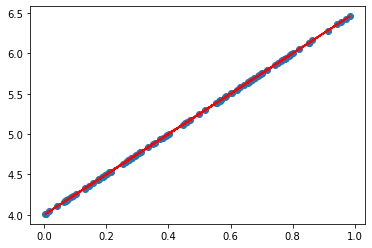

In [16]:
import matplotlib.pyplot as plt
plt.scatter(X, y)
plt.plot(X, line_model(X, w, b), c='r')
plt.show()

## 2. 小批量随机梯度下降法

In [17]:
'''
The General Classifier Based on Mini-Batch Stochastic Gradient Descent for Supervised Learning.
'''

import numpy as np
import random

'''
Data Restraint: numpy.ndarray.
Test Data Scale: 2683*6603.
Test Time Evaluation: Great! 
Design Style: Scikit-Learn, PyTorch.
Train Mode: Min-Batch.
'''

class Classifier:
    def __init__(self, epochs: int=200, batch_size: int=16, lr: float=0.1):
        '''
        :param epochs: max iteration, default: int=200.
        :param batch_size: batch size, default: int=16.
        :param lr: learning rate, default: float=0.1.

        '''
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
    
    def __data_matrix(self, X):
        '''
        :param X: data converted to augmented, numpy.ndarray.

        '''
        ones = np.ones(X.shape[0])
        return np.insert(X, 0, ones, axis=1)
    
    def __softmax(self, part):
        '''
        :param part: part of features, numpy.ndarray.

        '''
        part -= np.max(part, axis=1).reshape(-1, 1)
        return np.exp(part) / np.sum(np.exp(part))

    def __data_iter(self, X, y):
        '''
        :param X: features, numpy.ndarray.
        :param y: labels, numpy.ndarray.

        '''
        num_examples = len(X)
        indices = list(range(num_examples))
        random.shuffle(indices)
        for index in range(0, num_examples, self.batch_size):
            batch_indices = np.array(indices[index: min(index + self.batch_size, num_examples)])
            yield X[batch_indices], y[batch_indices]
    
    def fit(self, X, y, console: int=100, decay: int=20) -> None:
        '''
        :param X: train data, numpy.ndarray.
        :param y: correct labels, numpy.ndarray.
        :parm console: console output interval, default: int=100.
        :parm decay: learning rate deacy change interval, default: int=20.

        '''
        assert len(X.shape) == 2, 'please ensure data like: (2, 2) shape'
        assert len(y.shape) == 1, 'please ensure data like: (2,) shape'
        augmented, unique = self.__data_matrix(X), np.unique(y)
        self.num_classes = len(unique)
        indices = dict(zip(unique, range(self.num_classes)))
        self.weights = np.zeros((augmented.shape[1], self.num_classes), dtype=np.float64)
        for epoch in range(self.epochs):
            for step, (features, labels) in enumerate(self.__data_iter(augmented, y)):
                res = self.__softmax(features @ self.weights)
                obj = np.eye(self.num_classes)[[indices[value] for value in labels]]
                err = res - obj
                self.weights -= self.lr * (features.T @ err) / self.batch_size
                if (step + 1) % console == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'.format(epoch+1, self.epochs, step+1, len(X) // self.batch_size, np.linalg.norm(err)))
            # learning rate decay
            if (epoch + 1) % decay == 0:
                self.lr /= 3 # replace it with another schedule.
                
    def score(self, X, y) -> float:
        '''
        :param X: test data, numpy.ndarray.
        :param y: correct labels, numpy.ndarray.

        '''
        assert len(X.shape) == 2, 'please ensure data like: (2, 2) shape'
        assert len(y.shape) == 1, 'please ensure data like: (2,) shape'
        X = self.__data_matrix(X)
        corr, prob = 0, X @ self.weights
        predicted = np.argmax(prob, axis=1)
        corr += (predicted == y).sum()
        return corr / len(X)
    
    def predict(self, X):
        '''
        :param X: predict data, numpy.ndarray.

        '''
        assert len(X.shape) == 2, 'please ensure data like: (2, 2) shape'
        X = self.__data_matrix(X)
        prob = X @ self.weights
        return np.argmax(prob, axis=1)

In [18]:
# import packages and model
import scipy.io as sio

In [19]:
# load data
def process_data(url: str) -> tuple:
    data = sio.loadmat(url)
    return data['X'], data['class']

In [20]:
# get features and labels
features, labels = process_data('../textretrieval.mat')

In [21]:
# split data
def pretreat(features, labels) -> tuple:
    labels = np.argwhere(labels == 1)[:, 1]
    return features[:2000, :], features[2000:, :], labels[:2000], labels[2000:]

In [22]:
# get splited data
X_train, X_test, y_train, y_test = pretreat(features, labels)

In [23]:
# train model
# model = Classifier(epochs=200, batch_size=1, lr=0.1)
# model.fit(X_train, y_train)

In [24]:
# evaluate model
# model.score(X_test, y_test)

In [25]:
# predict result
# print((y_test == model.predict(X_test)).sum() / len(X_test))